## Finding the galactic plane

The galactic plane is a "bright", disk-shaped region where most objects in our galaxy lie. To extract it from most catalogs with precision we would need to construct a polygon (or better, a set of convex polygons) and merge the respective sub-regions, which is no easy task. 

The HiPSCat format subdivides the sky in pixels of equal area (HEALPix). This means that the higher the order of the pixel in the catalog, the higher the object density inside its region. Extracting catalog pixels according to their order should provide us a good approximation of the galactic plane.

In [1]:
import lsdb

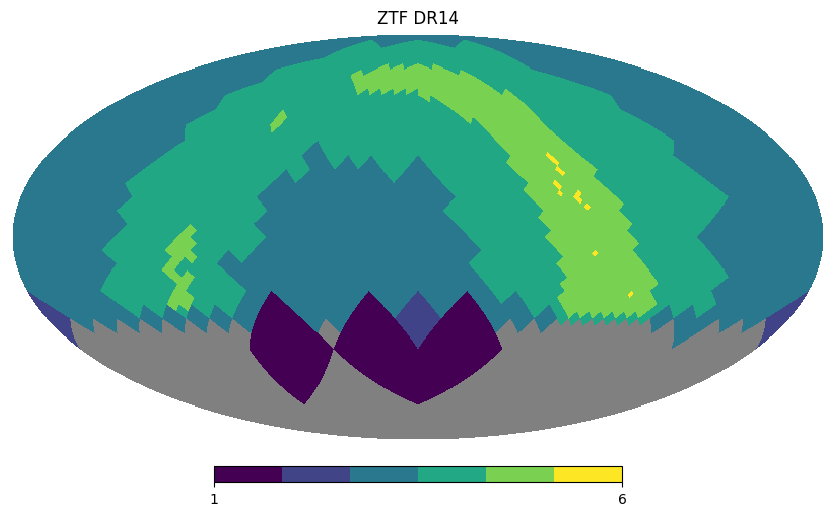

In [2]:
ztf_dr14 = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")
ztf_dr14.plot_pixels("ZTF DR14")

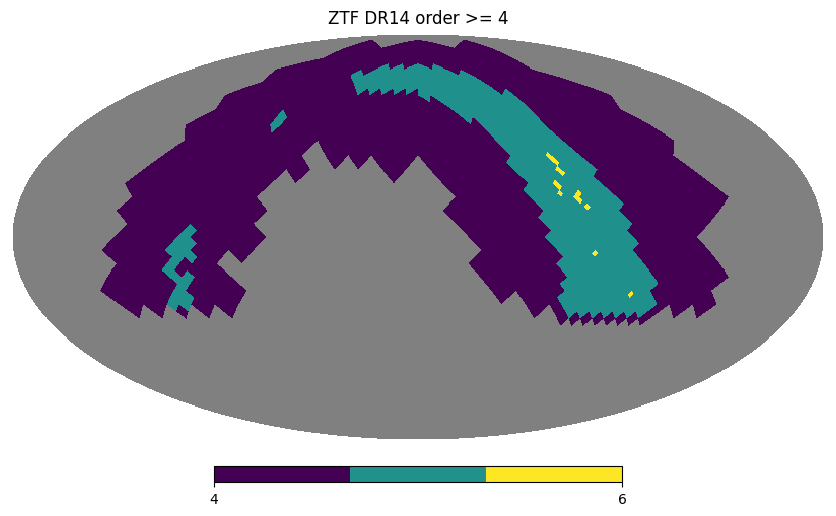

In [3]:
ztf_dr14_order4 = ztf_dr14.order_search(min_order=4)
ztf_dr14_order4.plot_pixels("ZTF DR14 order >= 4")

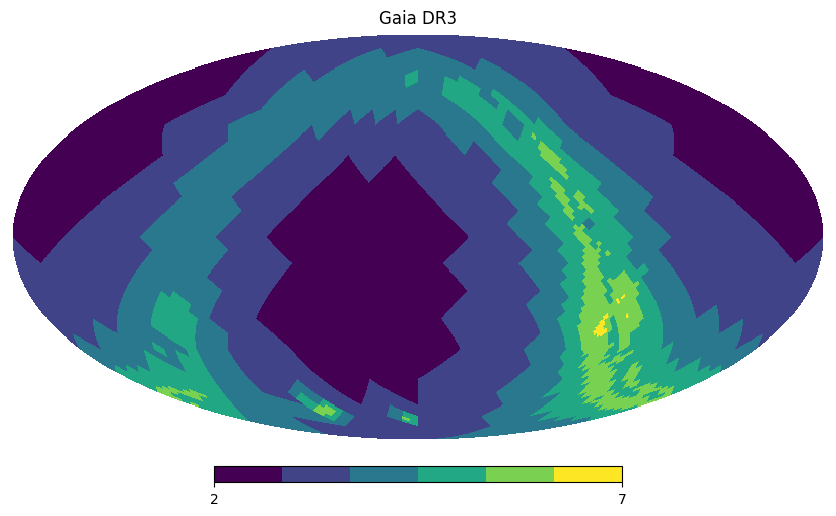

In [4]:
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/gaia_dr3/gaia")
gaia.plot_pixels("Gaia DR3")

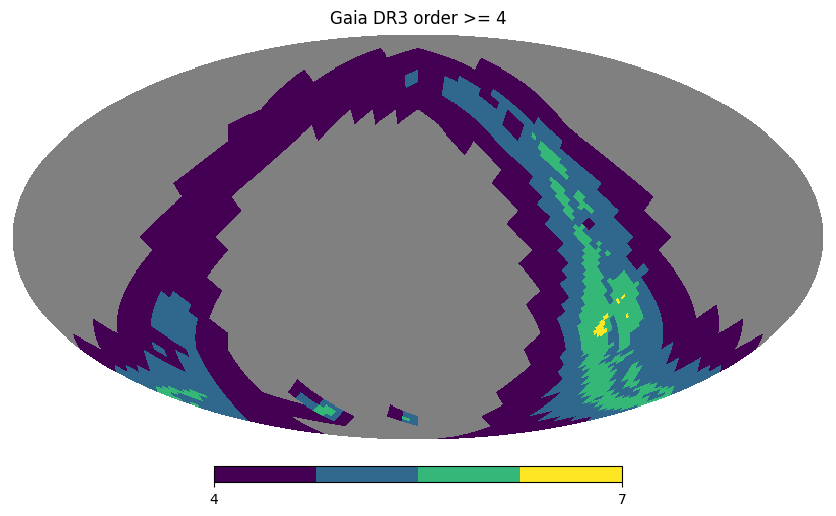

In [5]:
gaia_order_4 = gaia.order_search(min_order=4)
gaia_order_4.plot_pixels("Gaia DR3 order >= 4")

### Checking object coverage

Let's load the small Low-mass X-ray Binaries catalog (LMXB) and check what's the percentage of objects present in each of these filtered galactic planes.

In [6]:
import pandas as pd

lmxb = pd.read_csv("LMXB_cat.csv", sep=";", usecols=["Name", "RAdeg", "DEdeg"])
lmxb

,Name,RAdeg,DEdeg
0,NGC 104-X4,5.974937,-72.063908
1,NGC 104-X5,6.004075,-72.081474
2,NGC 104-X7,6.014558,-72.081094
3,NGC 104-X9,6.017767,-72.082803
4,NGC 104-W37,6.020862,-72.080908
...,...,...,...
355,4U 2129+47,322.859207,47.290123
356,CXOGlb J214022.1-231045,325.092208,-23.179325
357,X Cyg X-2,326.171467,38.321406
358,SAX J2224.9+5421,336.206875,54.386139


In [7]:
import numpy as np
import healpy as hp
from hipscat.pixel_math import HealpixPixel

def is_point_in_catalog(catalog, ra, dec):
    orders = np.unique([pixel.order for pixel in catalog.get_healpix_pixels()])
    for order in orders:
        nside = 2**order
        point_pixel = hp.ang2pix(nside, ra, dec, nest=True, lonlat=True)
        point_hp = HealpixPixel(order, point_pixel)
        if point_hp in catalog.hc_structure.pixel_tree:
            return 1
    return 0

def print_object_coverage(catalog, objects_df):
    objects_ra, objects_dec = objects_df["RAdeg"], objects_df["DEdeg"]
    contained = sum(is_point_in_catalog(catalog, ra, dec) for ra, dec in zip(objects_ra, objects_dec))
    coverage = round(contained / len(objects_df) * 100, 2)
    min_order = min(pixel.order for pixel in catalog.get_healpix_pixels())
    print(f"Coverage ({catalog.hc_structure.catalog_name} - order >= {min_order}): {coverage} %")

In [8]:
print_object_coverage(gaia, lmxb)
print_object_coverage(gaia_order_4, lmxb)

Coverage (gaia - order >= 2): 100.0 %
Coverage (gaia - order >= 4): 93.89 %


ZTF covers the entire northern sky from declination −28º.

In [9]:
lmxb_objects_in_ztf = lmxb[lmxb["DEdeg"] >= -28]
lmxb_objects_in_ztf

,Name,RAdeg,DEdeg
6,IGR J00291+5934,7.262675,59.571945
7,3U 0042+32,11.210494,33.019223
9,GRO J0422+32,65.428011,32.907483
11,AT2019wey,68.847000,55.376181
15,Swift J061223.0+701243,93.094279,70.211982
...,...,...,...
355,4U 2129+47,322.859207,47.290123
356,CXOGlb J214022.1-231045,325.092208,-23.179325
357,X Cyg X-2,326.171467,38.321406
358,SAX J2224.9+5421,336.206875,54.386139


In [10]:
print_object_coverage(ztf_dr14, lmxb_objects_in_ztf)
print_object_coverage(ztf_dr14_order4, lmxb_objects_in_ztf)

Coverage (ztf_dr14 - order >= 1): 100.0 %
Coverage (ztf_dr14 - order >= 4): 95.8 %


We performed HEALPix order filtering on Gaia and ZTF DR14 to approximately extract the pixels containing the galactic plane. We concluded that 95% of the objects in the small LMXB dataset that were covered by the complete surveys are present in the filtered catalogs.